In [335]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from scipy.integrate import quad
import scipy.special as sp

import qubic

from pylab import *
import camb.correlations as cc
plt.rc('figure', figsize=(16, 7))
plt.rc('font', size=15)
mpl.rcParams['image.cmap'] = 'jet'

# Compute $C_{\ell}$ from Kolmogorov power spectrum

In [336]:
def kolmogorov_correlation(r, r0=300):
    return np.where(r==0, 1, 2**(2/3)/sp.gamma(1/3)*(r/r0)**(1/3)*sp.kv(1/3, r/r0))

In [337]:
def angular_correlation(theta, h_atm=1000):
    r = 2*h_atm*np.sin(np.radians(theta)/2)
    return kolmogorov_correlation(r)

In [338]:
def cl_from_angular_correlation_int(l):
    print(l)
    def integrand(cos_theta):
        theta = np.degrees(np.arccos(cos_theta))
        legendre = sp.legendre(l)(cos_theta)
        return angular_correlation(theta) * legendre
    res, _ = quad(integrand, -1, 1)
    
    return 2 * np.pi * res

In [339]:
nside = 64
lmax = 3*nside - 1

ell = np.arange(lmax+1)
C_l = [cl_from_angular_correlation_int(l) for l in ell]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [340]:
C_l

[0.3741011289184177,
 0.2916400439335164,
 0.20401966238574326,
 0.1380341940244016,
 0.09384244389508176,
 0.06519962072891078,
 0.046555376661306845,
 0.03417393140038566,
 0.02573805537315585,
 0.019836234638341298,
 0.015601819758571889,
 0.01249253072847812,
 0.010161131806942822,
 0.008379888578651547,
 0.006995920477677905,
 0.005904317643108299,
 0.00503160607896129,
 0.00432535318708064,
 0.0037474922474644494,
 0.0032699469533976535,
 0.0028717078997460978,
 0.0025368438203283994,
 0.0022531258808430768,
 0.0020110611436089643,
 0.0018032036177067477,
 0.001623656533521712,
 0.0014677082425506786,
 0.0013315627479444014,
 0.0012121380922775775,
 0.0011069139756310887,
 0.001013815482642348,
 0.0009311235711570071,
 0.0008574055778346775,
 0.0007914608460743728,
 0.0007322778641586514,
 0.0006790002425299313,
 0.0006308995258600444,
 0.0005873533359033749,
 0.0005478276893456723,
 0.0005118626177457445,
 0.00047906040804864046,
 0.00044907593796497143,
 0.0004216086945861848,


In [341]:
delta_rho_map = hp.synfast(C_l, nside=nside, lmax=lmax)

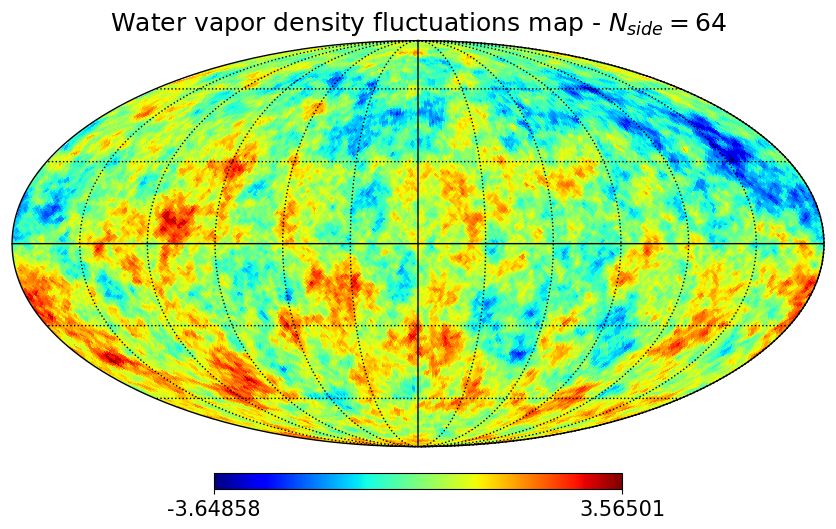

In [342]:
hp.mollview(delta_rho_map, title='Water vapor density fluctuations map - $N_{side}=64$', cmap='jet')
hp.graticule()

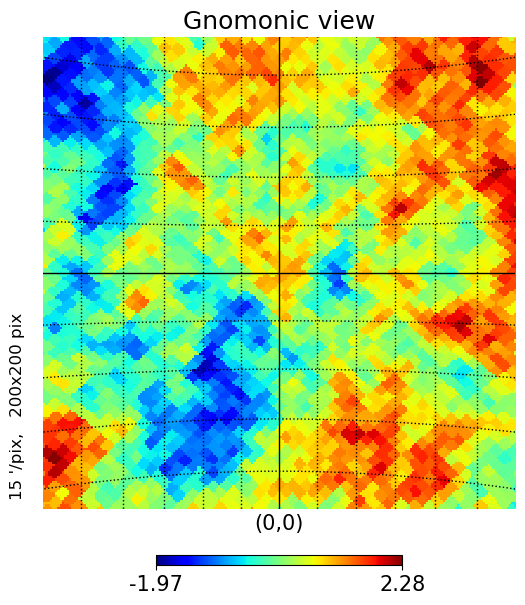

In [343]:
hp.gnomview(delta_rho_map, cmap='jet', reso=15, rot=(0, 0))
hp.graticule()

# Normalize random fluctuations

In [344]:
delta_rho = 0.01
delta_map = np.var(delta_rho_map)

normalized_delta_rho_map = delta_rho_map * np.sqrt(delta_rho / delta_map)

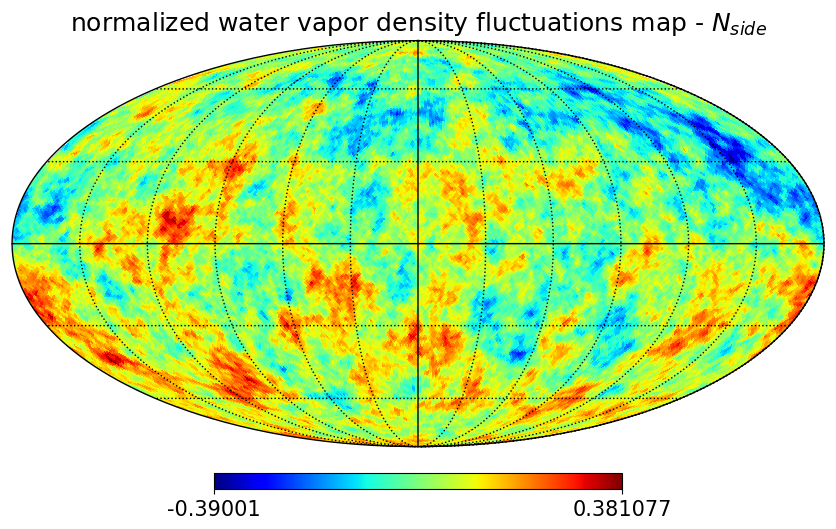

In [345]:
hp.mollview(normalized_delta_rho_map, title='normalized water vapor density fluctuations map - $N_{side}$', cmap='jet')
hp.graticule()

In [346]:
def get_mean_water_vapor_density(altitude, rho_0=1.225, h_h2o=835):
    return rho_0 * np.exp(-np.log(2) * (altitude - 5190) /h_h2o)

rho = get_mean_water_vapor_density(1000 + 5000)
rho_map = rho + normalized_delta_rho_map

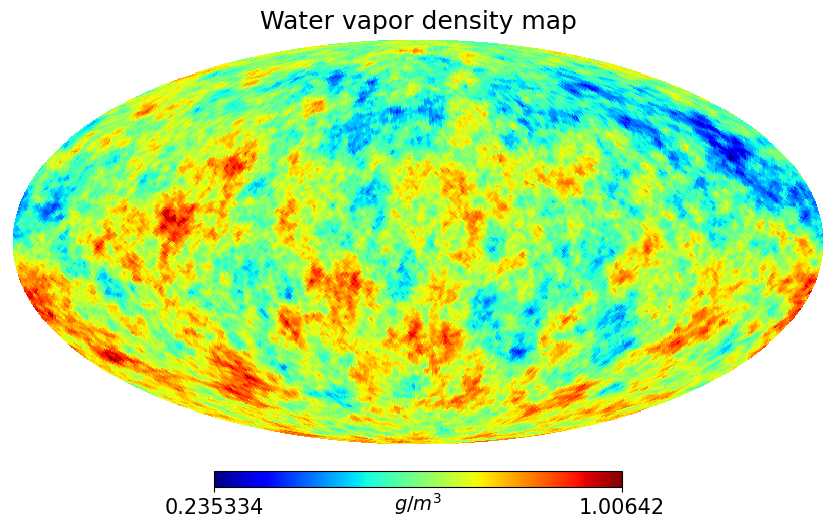

In [347]:
hp.mollview(rho_map, cmap='jet', title='Water vapor density map', unit='$g/m^3$')

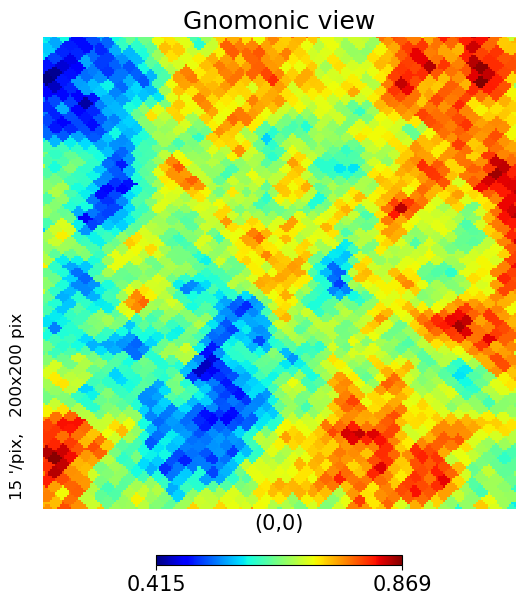

In [348]:
hp.gnomview(rho_map, cmap='jet', reso=15)

# Testing JC Code

In [349]:
def ctheta_2_cell(theta_deg, ctheta, lmax, pol=False, normalization=1.):
    ### this is how camb recommends to prepare the x = cos(theta) values for integration
    ### These x values do not contain x=1 so we have. to do this case separately
    x, w = np.polynomial.legendre.leggauss(lmax+1)
    xdeg = np.degrees(np.arccos(x))

    ### We first replace theta=0 by 0 and do that case separately
    myctheta = ctheta.copy()
    myctheta[0] = 0
    ### And now we fill the array that should include polarization (we put zeros there)
    ### with the values of our imput c(theta) interpolated at the x locations
    allctheta = np.zeros((len(x), 4))
    allctheta[:,0] = np.interp(xdeg, theta_deg, myctheta)

    ### Here we call the camb function that does the transform to Cl
    clth = cc.corr2cl(allctheta, x,  w, lmax)
    lll = np.arange(lmax+1)

    ### the special case x=1 corresponds to theta=0 and add 2pi times c(theta=0) to the Cell
    return lll, clth[:,0]+ctheta[0]*normalization

In [350]:
nth = 10000

theta = np.linspace(0,180,nth)
ctheta = angular_correlation(theta)

lll, dell = ctheta_2_cell(theta, ctheta, lmax, normalization=0)
cell = 2*np.pi / (lll*(lll+1)) * dell
cell[0] = C_l[0]

In [351]:
map_JC = hp.synfast(cell, nside)

In [352]:
cell

array([3.74101129e-01, 2.91636460e-01, 2.04016070e-01, 1.38030594e-01,
       9.38388380e-02, 6.51960104e-02, 4.65517629e-02, 3.41703148e-02,
       2.57344363e-02, 1.98326133e-02, 1.55981963e-02, 1.24889052e-02,
       1.01575041e-02, 8.37625872e-03, 6.99228838e-03, 5.90068321e-03,
       5.02796919e-03, 4.32171367e-03, 3.74384984e-03, 3.26630130e-03,
       2.86805855e-03, 2.53319046e-03, 2.24946878e-03, 2.00740099e-03,
       1.79954084e-03, 1.61999114e-03, 1.46404002e-03, 1.32789143e-03,
       1.20846344e-03, 1.10323577e-03, 1.01013353e-03, 9.27437689e-04,
       8.53715597e-04, 7.87766601e-04, 7.28579196e-04, 6.75296995e-04,
       6.27191547e-04, 5.83640473e-04, 5.44109789e-04, 5.08139521e-04,
       4.75331944e-04, 4.45341918e-04, 4.17868918e-04, 3.92650444e-04,
       3.69456540e-04, 3.48085075e-04, 3.28357774e-04, 3.10117030e-04,
       2.93223215e-04, 2.77552309e-04, 2.62993887e-04, 2.49449387e-04,
       2.36830642e-04, 2.25058612e-04, 2.14062292e-04, 2.03777770e-04,
      

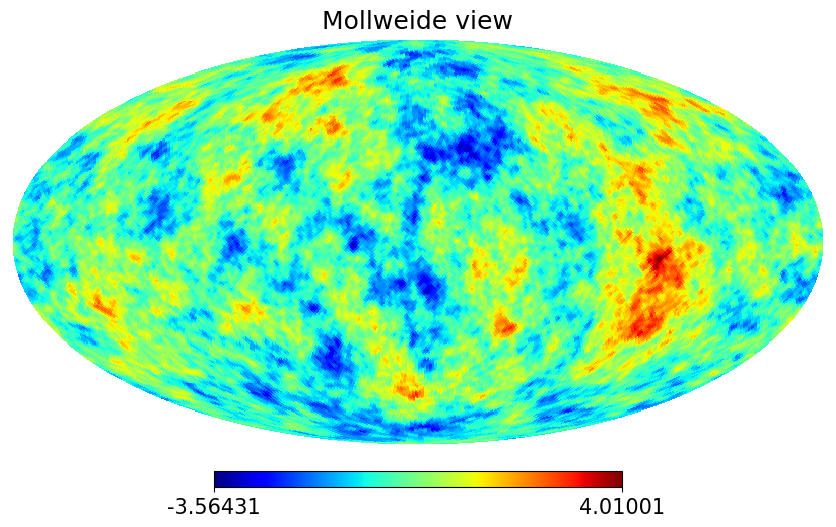

In [353]:
hp.mollview(map_JC)

# Comparison between the methods

In [354]:
C_l_JC = cell
C_l_Tom = C_l

In [355]:
print(len(C_l_JC), len(C_l_Tom))

192 192


In [356]:
C_l_maps_JC = hp.anafast(map_JC, lmax=lmax) 
C_l_maps_Tom = hp.anafast(delta_rho_map, lmax=lmax)

Text(0.5, 1.0, 'Angular Kolmogorov Power Spectrum')

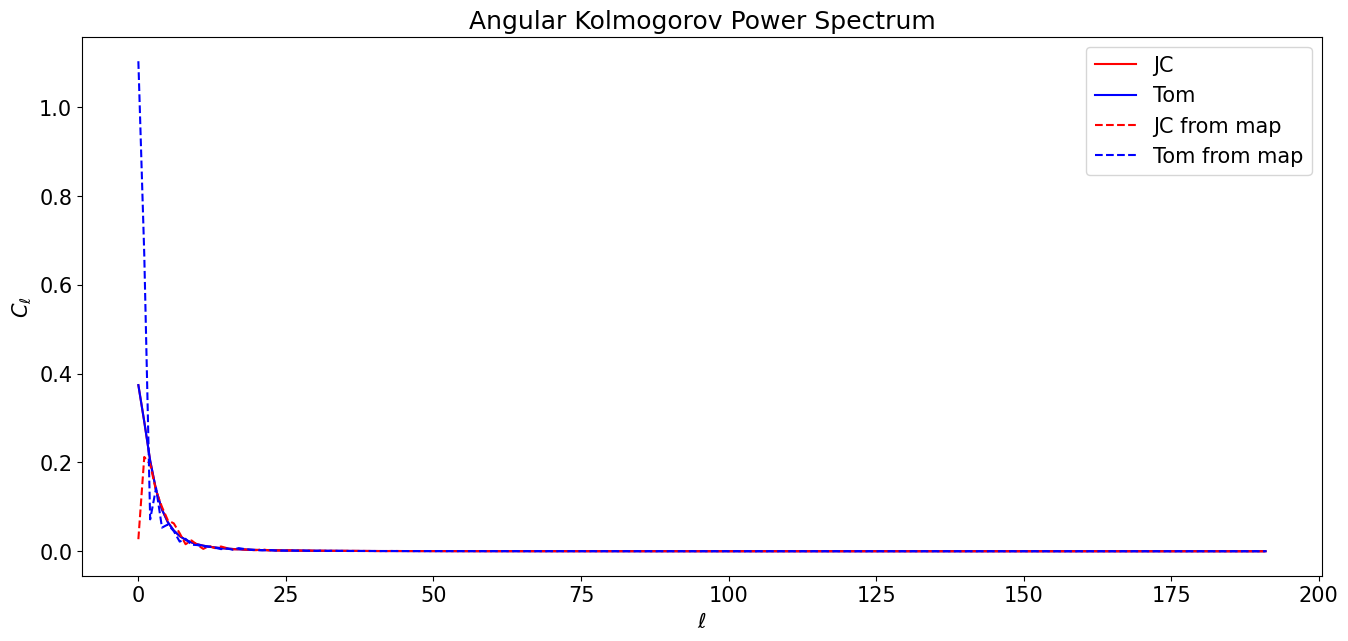

In [357]:
plt.plot(C_l_JC, 'r', label='JC')
plt.plot(C_l_Tom, 'b', label='Tom') 
plt.plot(C_l_maps_JC, '--r', label='JC from map')
plt.plot(C_l_maps_Tom, '--b', label='Tom from map')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.legend()
plt.title('Angular Kolmogorov Power Spectrum')

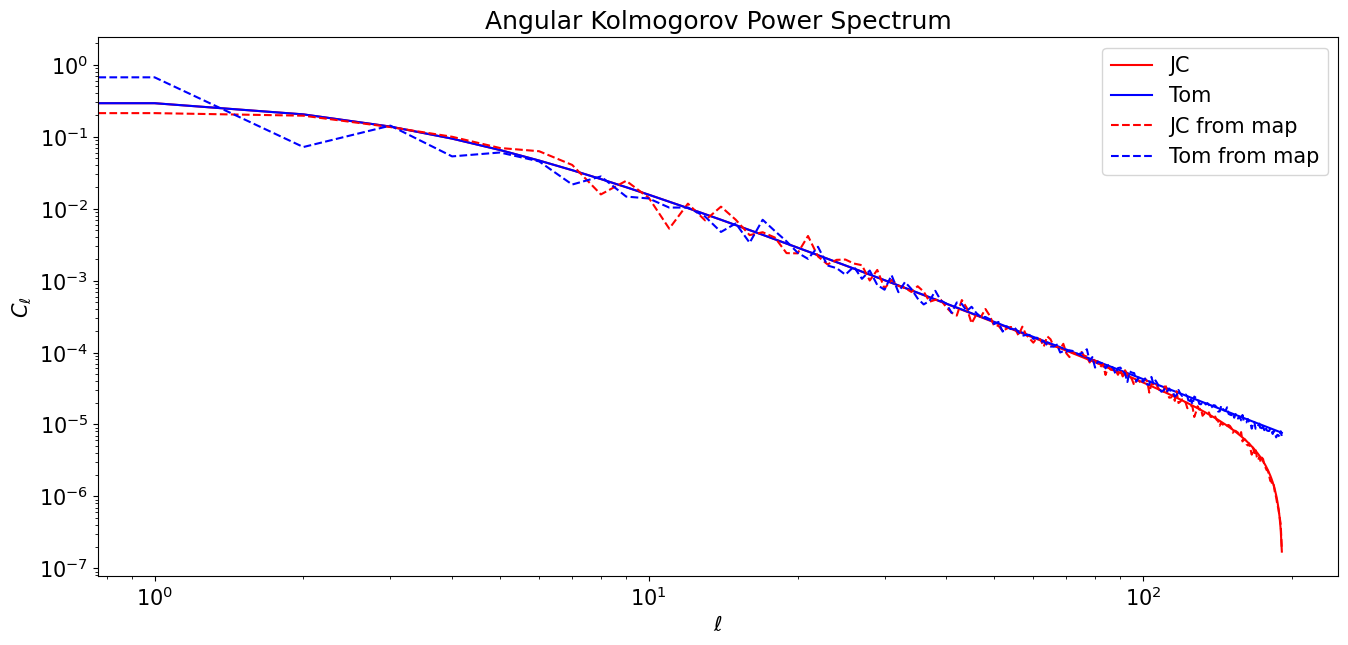

In [358]:
plt.plot(C_l_JC, 'r', label='JC')
plt.plot(C_l_Tom, 'b', label='Tom') 
plt.plot(C_l_maps_JC, '--r', label='JC from map')
plt.plot(C_l_maps_Tom, '--b', label='Tom from map')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.legend()
plt.title('Angular Kolmogorov Power Spectrum')
plt.xscale('log')
plt.yscale('log')